In [1]:
import pybullet as p
import pybullet_data
import imageio
import numpy as np
import pickle
import PIL.Image
import os
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
print(os.getcwd(), "this is the current working directory")

pybullet build time: May 20 2022 19:45:31


/home/ubuntu/bayes3d/experiments/physics this is the current working directory


In [2]:
def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [3]:
def object_pose_in_camera_frame(object_id, view_matrix):
    object_pos, object_orn = p.getBasePositionAndOrientation(object_id) # world frame
    world2cam = np.array(view_matrix).reshape([4,4]).T # world --> cam 
    object_transform_matrix = np.eye(4)
    object_transform_matrix[:3, :3] = np.reshape(p.getMatrixFromQuaternion(object_orn), (3, 3))
    object_transform_matrix[:3, 3] = object_pos
    return world2cam @ object_transform_matrix

In [10]:
# Initialize the PyBullet physics simulation
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Set up the simulation environment
p.setGravity(0, 0, -10)
p.setTimeStep(1.0/240.0)
plane_id = p.loadURDF("plane.urdf")
# Set the friction coefficient for the plane
friction_coefficient = 0.0  # Adjust this value as needed
p.changeDynamics(plane_id, -1, lateralFriction=friction_coefficient)

# Create the first sphere
sphere_radius1 = 0.5
sphere_mass1 = 1
sphere_position1 = [-2, 0, 0.5]
sphere_start_velocity1 = [4, 0, 0]
mesh_scale = [0.5,0.5,0.5]
# sphere_shape1 = p.createCollisionShape(p.GEOM_BOX, halfExtents = [0.5,0.5,0.5])
sphere_shape1 = p.createCollisionShape(shapeType=p.GEOM_MESH, fileName="assets/cube.obj", meshScale=mesh_scale)
sphere_id1 = p.createMultiBody(sphere_mass1, sphere_shape1, basePosition=sphere_position1)
p.resetBaseVelocity(sphere_id1, sphere_start_velocity1)
p.changeDynamics(sphere_id1, -1, restitution = 1)
object_id = sphere_id1

# Arrays for serialization 
frames = []
sphere_loc = []
sphere_orn = []
obj_cam_poses   = []

w = 480
h = 360


# Step through the simulation
for i in range(360):
    p.stepSimulation()

    if i%4 ==0:
        # record positions of spheres

        view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition=[0, 0, 0], distance=5, yaw=0, pitch=-30, roll=0,
                                                        upAxisIndex=2)
        proj_matrix = p.computeProjectionMatrixFOV(fov=60, aspect=float(w) / h, nearVal=0.1, farVal=100.0)

        (_, _, px, d, _) = p.getCameraImage(width=w, height=h, viewMatrix=view_matrix,
                                            projectionMatrix=proj_matrix, renderer=p.ER_BULLET_HARDWARE_OPENGL)
        rgb_array = np.array(px, dtype=np.uint8)
        rgb_array = np.reshape(rgb_array, (h, w, 4))
        rgb_array = rgb_array[:, :, :3]  # remove alpha channel
        frames.append(rgb_array)

        obj_cam_poses.append(object_pose_in_camera_frame(object_id, view_matrix))

plane_cam_pose = object_pose_in_camera_frame(0, view_matrix)

# Save GIF and serialize the sphere locations

# imageio.mimsave('balls-simulation.gif', frames, 'GIF', duration=1000 * (1/15))

# with open('sph_loc.pkl', 'wb') as f:
#     pickle.dump(sphere_loc, f)
# with open('sph_loc2.pkl', 'wb') as f:
#     pickle.dump(sphere_loc2, f)

p.disconnect()


In [11]:
display_video(frames, framerate=60)

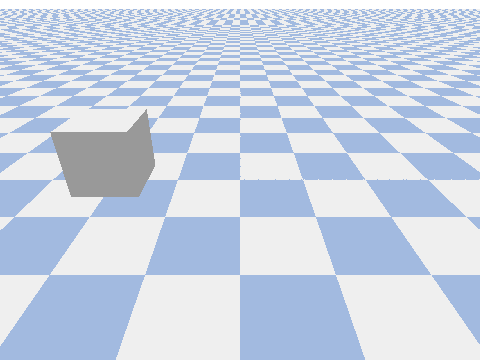

In [66]:
PIL.Image.fromarray(frames[0])

In [7]:
array_dict = {
    'box': obj_cam_poses,
    'plane': plane_cam_pose
}

np.savez('poses_camera_frame.npz', **array_dict)


In [79]:
a = np.load('poses_camera_frame.npz')

In [77]:
a['plane']

array([[ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.5 ,  0.87,  0.  ],
       [ 0.  , -0.87,  0.5 , -5.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [92]:
intrinsic_matrix = np.zeros((3, 3))

if not np.isclose(p_mat[3, :3], 0).all():
    intrinsic_matrix[0, 0] = p_mat[0, 0] / p_mat[3, 0]
    intrinsic_matrix[1, 1] = p_mat[1, 1] / p_mat[3, 1]
    intrinsic_matrix[0, 2] = p_mat[0, 2] / p_mat[3, 0]
    intrinsic_matrix[1, 2] = p_mat[1, 2] / p_mat[3, 1]
    intrinsic_matrix[2, 2] = 1.0

/tmp/ipykernel_2021/1272419888.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  intrinsic_matrix[0, 0] = p_mat[0, 0] / p_mat[3, 0]
/tmp/ipykernel_2021/1272419888.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  intrinsic_matrix[1, 1] = p_mat[1, 1] / p_mat[3, 1]
/tmp/ipykernel_2021/1272419888.py:6: RuntimeWarning: invalid value encountered in scalar divide
  intrinsic_matrix[0, 2] = p_mat[0, 2] / p_mat[3, 0]
/tmp/ipykernel_2021/1272419888.py:7: RuntimeWarning: invalid value encountered in scalar divide
  intrinsic_matrix[1, 2] = p_mat[1, 2] / p_mat[3, 1]


In [12]:
p_mat = np.array(proj_matrix).reshape([4,4])

In [14]:
p_mat.T

array([[ 1.29903805,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.73205078,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.002002  , -0.2002002 ],
       [ 0.        ,  0.        , -1.        ,  0.        ]])

In [ ]:
# 311.769